### imports and load dataset

In [5]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler

from sklearn.metrics import accuracy_score, f1_score, classification_report


from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB


In [6]:
df = pd.read_csv('../credit_loan/loan_eda_cleaned.csv')
df.head()

,customer_id,age,occupation_status,years_employed,annual_income,credit_score,credit_history_years,savings_assets,current_debt,defaults_on_file,delinquencies_last_2yrs,derogatory_marks,product_type,loan_intent,loan_amount,interest_rate,debt_to_income_ratio,loan_to_income_ratio,payment_to_income_ratio,loan_status
0,CUST100000,40,Employed,17.2,25579,692,5.3,895,10820,0,0,0,Credit Card,Business,600,17.02,0.423,0.023,0.008,1
1,CUST100001,33,Employed,7.3,43087,627,3.5,169,16550,0,1,0,Personal Loan,Home Improvement,53300,14.10,0.384,1.237,0.412,0
2,CUST100002,42,Student,1.1,20840,689,8.4,17,7852,0,0,0,Credit Card,Debt Consolidation,2100,18.33,0.377,0.101,0.034,1
3,CUST100003,53,Student,0.5,29147,692,9.8,1480,11603,0,1,0,Credit Card,Business,2900,18.74,0.398,0.099,0.033,1
4,CUST100004,32,Employed,12.5,63657,630,7.2,209,12424,0,0,0,Personal Loan,Education,99600,13.92,0.195,1.565,0.522,1


### labelencoding and onehotencode

In [7]:
label_dict = {}
df_copy = df.copy().drop(columns=['customer_id'])
cat_cols = df_copy.select_dtypes(include=['object']).columns
for col in cat_cols:
    le = LabelEncoder()
    df_copy[col] = le.fit_transform(df_copy[col])
    label_dict[col] = le

In [8]:
# One-Hot Encoding - feito com pandas por ser mais rapido em execução
df_onehot = df.copy().drop(columns=['customer_id'])
df_onehot = pd.get_dummies(df_onehot, columns=df_onehot.select_dtypes(include=['object']).columns)


### split target and train & test

In [9]:
TARGET_COLUMN = 'loan_status'
X = df_copy.drop(columns=[TARGET_COLUMN])
y = df_copy[TARGET_COLUMN]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [10]:
## split for linear models
X_scaler = df_copy.drop(columns=[TARGET_COLUMN])
y_scaler = df_copy[TARGET_COLUMN]
X_train_scaler, X_test_scaler, y_train_scaler, y_test_scaler = train_test_split(X_scaler, y_scaler, test_size=0.2, random_state=42, stratify=y_scaler)

### standard

In [11]:
## Standard Scaler only for linear models
sclaer = StandardScaler()
X_train_scaled = sclaer.fit_transform(X_train_scaler)
X_test_scaled = sclaer.transform(X_test_scaler)

### define the model

In [12]:
modelos_linear= {
    'Logistic Regression':LogisticRegression(),
    'SVM':SVC(),
    'Naive Bayes':GaussianNB()
}
modelos_tree = {
    'Decision Tree':DecisionTreeClassifier(),
    'Random Forest':RandomForestClassifier(),
    'Gradient Boosting':GradientBoostingClassifier()
}

### train and evaluate models

In [19]:
import matplotlib.pyplot as plt
from sklearn.metrics import (
    confusion_matrix, ConfusionMatrixDisplay,
    roc_curve, RocCurveDisplay,
    precision_recall_curve, PrecisionRecallDisplay
)
import joblib

In [20]:
def avaliar (modelo, X_test, y_test, nome_modelo):
    y_pred = modelo.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap='Blues')
    plt.title(f'Matriz de Confusão - {nome_modelo}')
    plt.show()
    if hasattr(modelo, "predict_proba"):
        y_proba = modelo.predict_proba(X_test)[:, 1]

        RocCurveDisplay.from_predictions(y_test, y_proba)
        plt.title(f'Curva ROC - {nome_modelo}')
        plt.show()

        PrecisionRecallDisplay.from_predictions(y_test, y_proba)
        plt.title(f'Curva Precision-Recall - {nome_modelo}')
        plt.show()

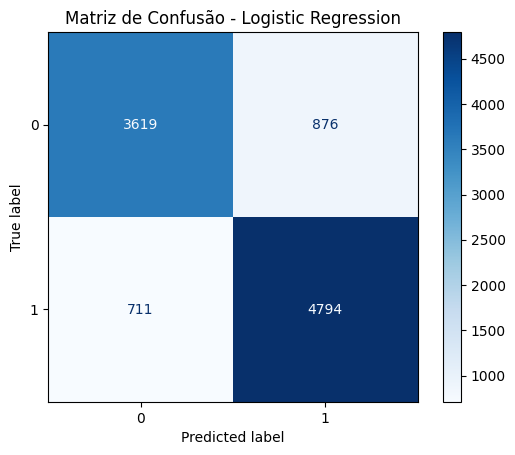

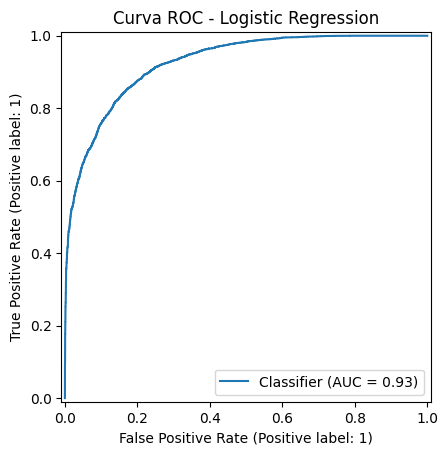

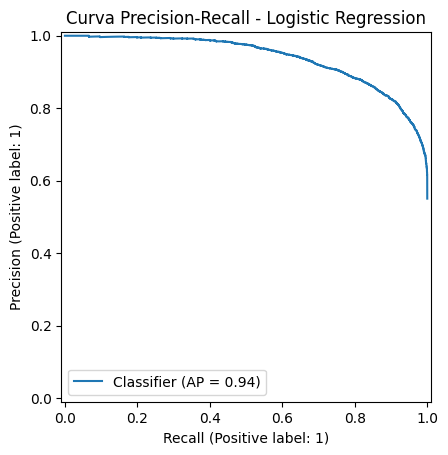

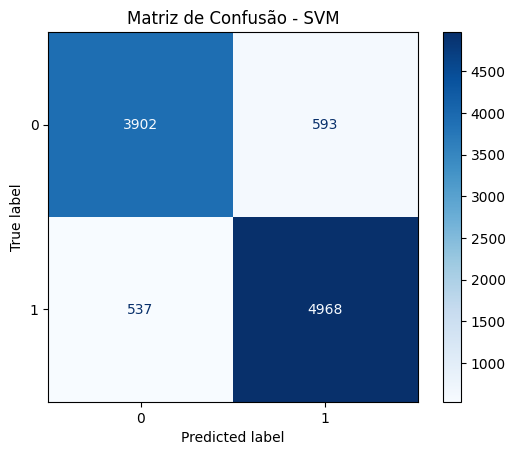

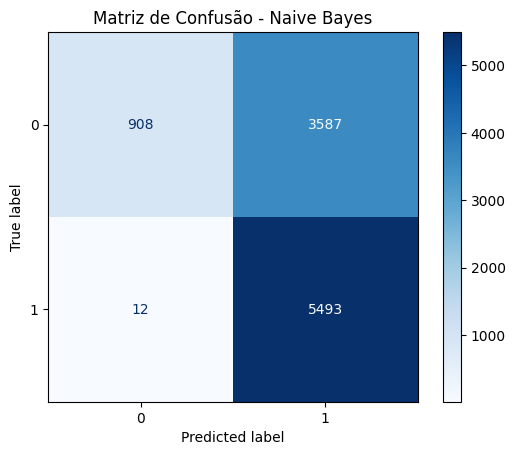

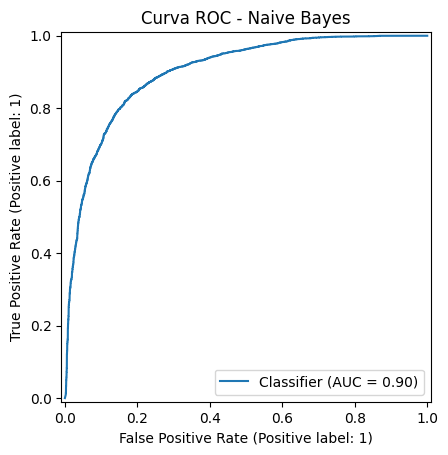

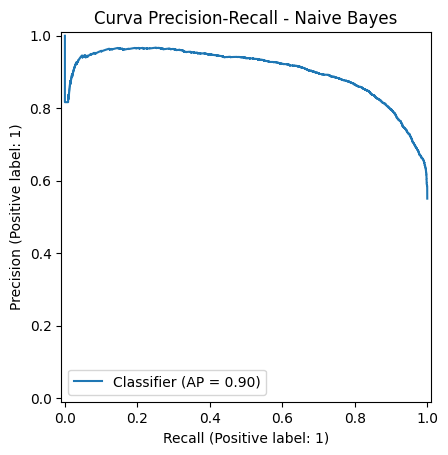

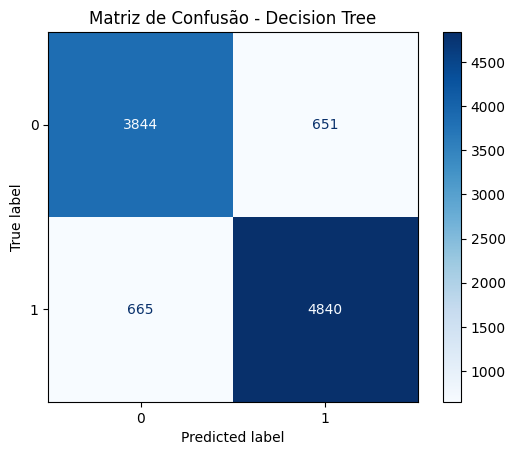

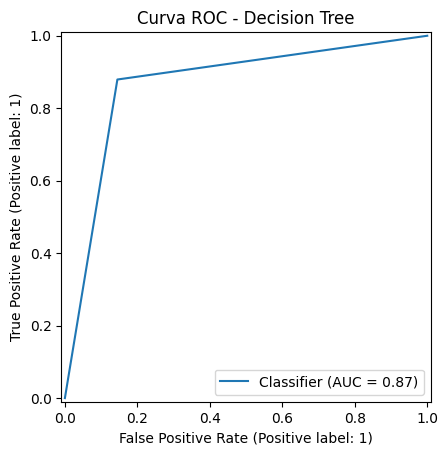

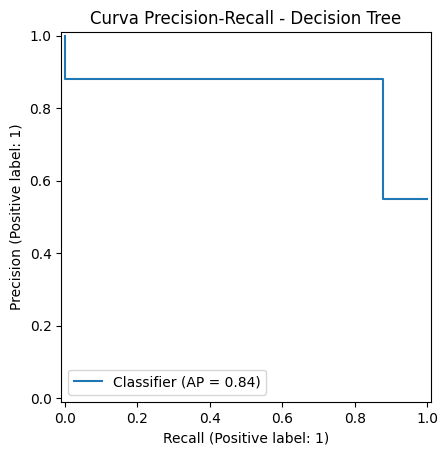

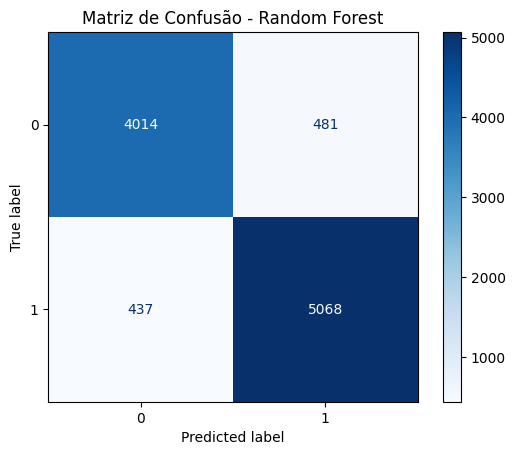

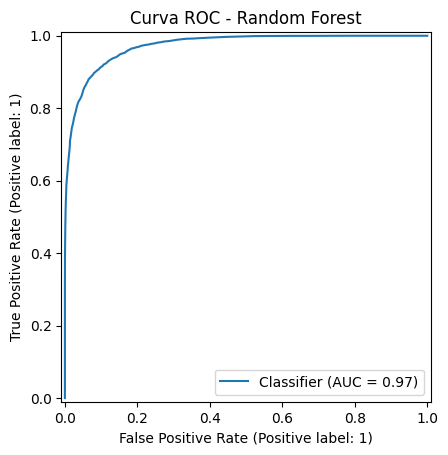

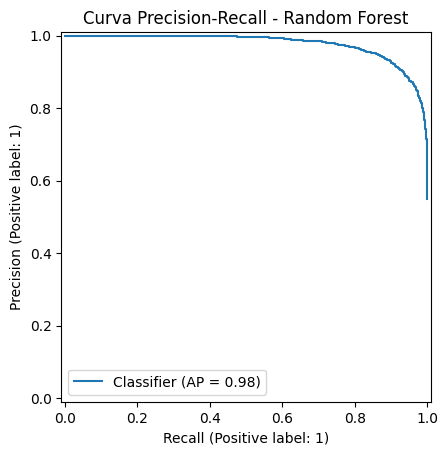

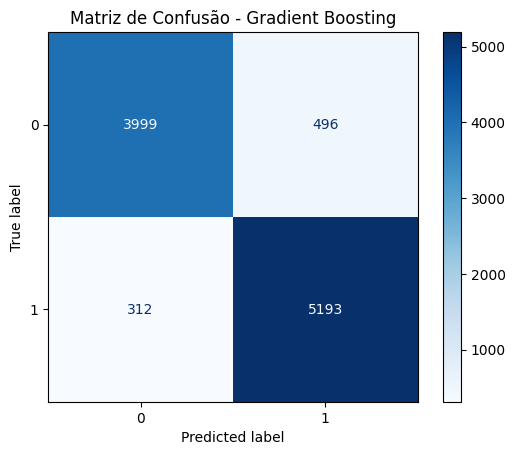

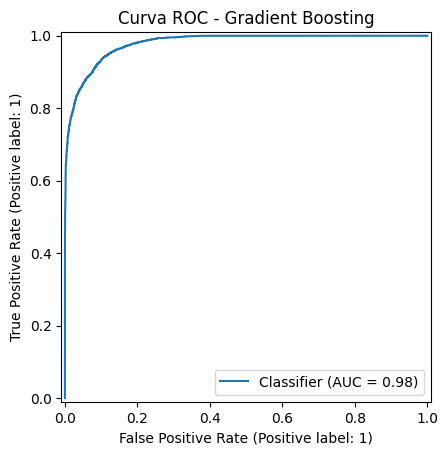

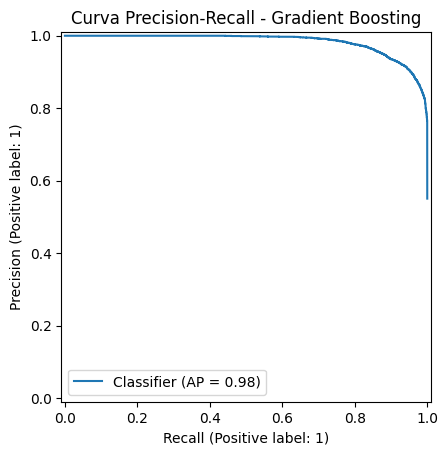

Modelo: Logistic Regression - Acurácia: 0.8413 - F1-Score: 0.8410
Modelo: SVM - Acurácia: 0.8870 - F1-Score: 0.8869
Modelo: Naive Bayes - Acurácia: 0.6401 - F1-Score: 0.5654
Modelo: Decision Tree - Acurácia: 0.8684 - F1-Score: 0.8684
Modelo: Random Forest - Acurácia: 0.9082 - F1-Score: 0.9082
Modelo: Gradient Boosting - Acurácia: 0.9192 - F1-Score: 0.9190


In [23]:
resultados = []

for nome_modelo, modelo in modelos_linear.items():
    modelo.fit(X_train_scaled, y_train_scaler)
    y_pred = modelo.predict(X_test_scaled)
    acc = accuracy_score(y_test_scaler, y_pred)
    f1 = f1_score(y_test_scaler, y_pred, average='weighted')
    resultados.append((nome_modelo, acc, f1))
    avaliar(modelo, X_test_scaled, y_test_scaler, nome_modelo)
    joblib.dump(modelo, f'../modelos/{nome_modelo.replace(" ", "_").lower()}_model.pkl')
    
for nome_modelo, modelo in modelos_tree.items():
    modelo.fit(X_train, y_train)
    y_pred = modelo.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')
    resultados.append((nome_modelo, acc, f1))
    avaliar(modelo, X_test, y_test, nome_modelo)
    joblib.dump(modelo, f'../modelos/{nome_modelo.replace(" ", "_").lower()}_model.pkl')

for resultado in resultados:
    print(f'Modelo: {resultado[0]} - Acurácia: {resultado[1]:.4f} - F1-Score: {resultado[2]:.4f}')

In [14]:
df_resultados = pd.DataFrame(resultados, columns=['Modelo', 'Acurácia', 'F1-Score'])
df_resultados.sort_values(by='F1-Score', ascending=False)


,Modelo,Acurácia,F1-Score
5,Gradient Boosting,0.9192,0.919020
4,Random Forest,0.9091,0.909054
1,SVM,0.8870,0.886932
3,Decision Tree,0.8709,0.870917
0,Logistic Regression,0.8413,0.840988
2,Naive Bayes,0.6401,0.565405


In [15]:
best_model_name = df_resultados.sort_values(by='F1-Score', ascending=False).iloc[0]['Modelo']
print(f'O melhor modelo é: {best_model_name}')

O melhor modelo é: Gradient Boosting


In [24]:
if best_model_name in modelos_linear:
    melhor_modelo = modelos_linear[best_model_name]
    X_train_ref = X_train_scaled
    X_test_ref = X_test_scaled
    y_test_ref = y_test_scaler
else:
    melhor_modelo = modelos_tree[best_model_name]
    X_train_ref = X_train
    X_test_ref = X_test
    y_test_ref = y_test

In [27]:
from sklearn.inspection import permutation_importance
def importancia_variaveis(modelo, X_train, X_test, y_test, nome_modelo):
    print("\n=== Importância das Variáveis ===\n")

    # Árvore
    if hasattr(modelo, "feature_importances_"):
        df_imp = pd.DataFrame({
            "feature": X_train.columns,
            "importance": modelo.feature_importances_
        }).sort_values("importance", ascending=False)

    # Modelo linear
    elif hasattr(modelo, "coef_"):
        coef = modelo.coef_[0]
        df_imp = pd.DataFrame({
            "feature": X_train.columns,
            "coef": coef,
            "abs_coef": abs(coef)
        }).sort_values("abs_coef", ascending=False)

    # Qualquer outro modelo → permutation importance
    else:
        result = permutation_importance(modelo, X_test, y_test, 
                                        n_repeats=10, random_state=42)

        df_imp = pd.DataFrame({
            "feature": X_train.columns,
            "importance": result.importances_mean
        }).sort_values("importance", ascending=False)

    # Mostra tabela
    print(df_imp)

    # Gráfico
    plt.figure(figsize=(8, 6))
    plt.barh(df_imp.iloc[:, 0], df_imp.iloc[:, -1])
    plt.title(f"Importância das Variáveis - {nome_modelo}")
    plt.gca().invert_yaxis()
    plt.show()



=== Importância das Variáveis ===

                    feature  importance
4              credit_score    0.399006
15     debt_to_income_ratio    0.258622
5      credit_history_years    0.068380
12              loan_intent    0.061841
9   delinquencies_last_2yrs    0.055965
8          defaults_on_file    0.054653
16     loan_to_income_ratio    0.050382
2            years_employed    0.016499
11             product_type    0.011839
10         derogatory_marks    0.006624
14            interest_rate    0.006377
17  payment_to_income_ratio    0.005209
13              loan_amount    0.002259
6            savings_assets    0.001291
1         occupation_status    0.000407
0                       age    0.000371
3             annual_income    0.000274
7              current_debt    0.000000


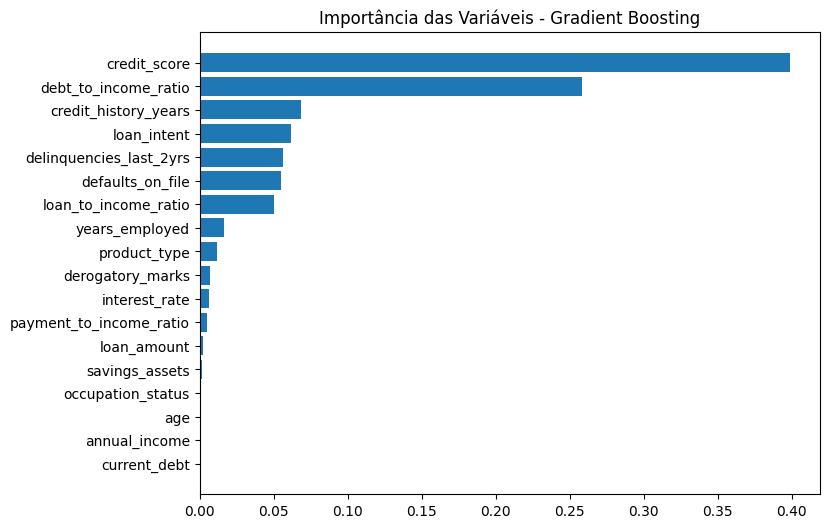

In [28]:
importancia_variaveis(
    melhor_modelo,
    X_train_ref,
    X_test_ref,
    y_test_ref,
    best_model_name
    
)
